2025-04-27 11:57:27.731893: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745755047.947243      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745755048.011219      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


GPU detected: /device:GPU:0


I0000 00:00:1745755060.450168      31 gpu_device.cc:2022] Created device /device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745755060.450796      31 gpu_device.cc:2022] Created device /device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5
I0000 00:00:1745755071.188330      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1745755071.188557      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Epoch 1/20


I0000 00:00:1745755093.144832      76 cuda_dnn.cc:529] Loaded cuDNN version 90300


27649/27649 ━━━━━━━━━━━━━━━━━━━━ 393s 14ms/step - accuracy: 0.6433 - loss: 0.9573 - val_accuracy: 0.7988 - val_loss: 0.5916 - learning_rate: 0.0010
Epoch 2/20
27649/27649 ━━━━━━━━━━━━━━━━━━━━ 388s 14ms/step - accuracy: 0.7835 - loss: 0.6457 - val_accuracy: 0.8062 - val_loss: 0.5713 - learning_rate: 0.0010
Epoch 3/20
27649/27649 ━━━━━━━━━━━━━━━━━━━━ 388s 14ms/step - accuracy: 0.7900 - loss: 0.6280 - val_accuracy: 0.8092 - val_loss: 0.5642 - learning_rate: 0.0010
Epoch 4/20
27649/27649 ━━━━━━━━━━━━━━━━━━━━ 388s 14ms/step - accuracy: 0.7950 - loss: 0.6178 - val_accuracy: 0.8112 - val_loss: 0.5682 - learning_rate: 0.0010
Epoch 5/20
27649/27649 ━━━━━━━━━━━━━━━━━━━━ 388s 14ms/step - accuracy: 0.7988 - loss: 0.6119 - val_accuracy: 0.8162 - val_loss: 0.5580 - learning_rate: 0.0010
Epoch 6/20
27649/27649 ━━━━━━━━━━━━━━━━━━━━ 388s 14ms/step - accuracy: 0.8016 - loss: 0.6066 - val_accuracy: 0.8183 - val_loss: 0.5579 - learning_rate: 0.0010
Epoch 7/20
27649/27649 ━━━━━━━━━━━━━━━━━━━━ 388s 14ms/ste

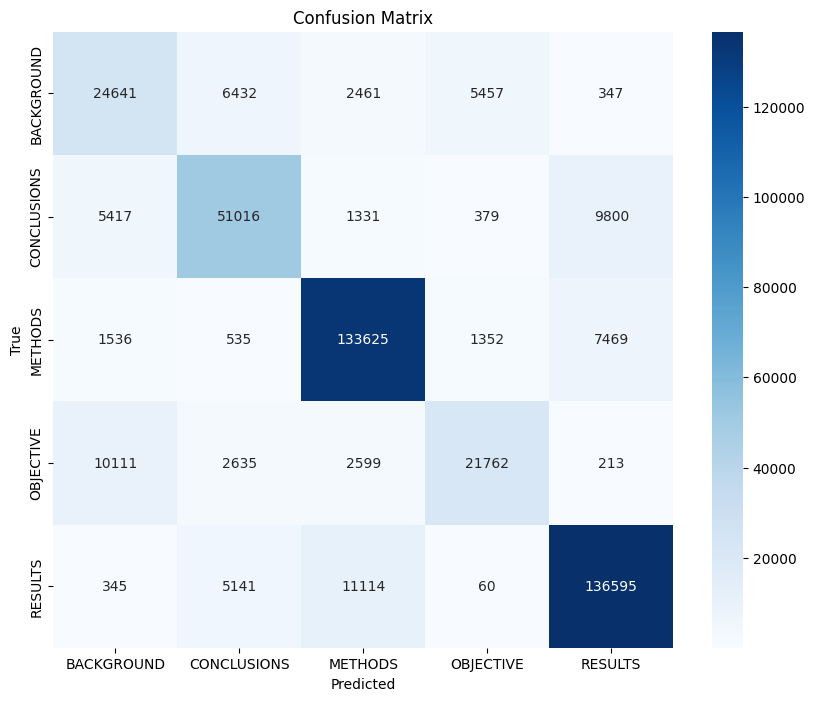

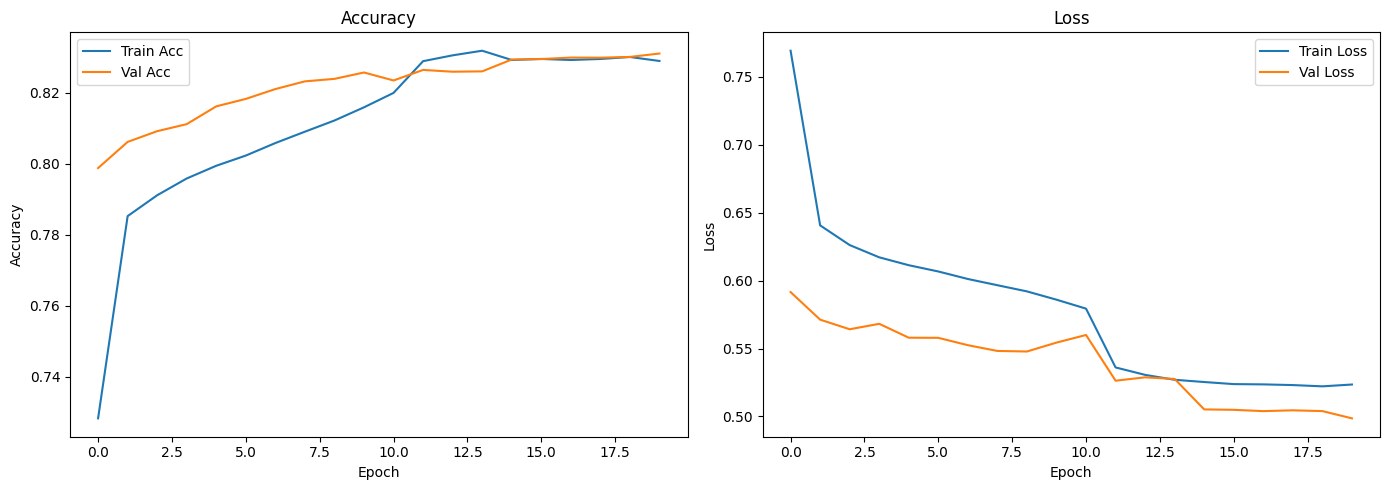

922/922 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

--- Final Test Set Evaluation ---
              precision    recall  f1-score   support

  BACKGROUND       0.60      0.62      0.61      2663
 CONCLUSIONS       0.78      0.74      0.76      4426
     METHODS       0.88      0.92      0.90      9751
   OBJECTIVE       0.74      0.60      0.67      2377
     RESULTS       0.89      0.89      0.89     10276

    accuracy                           0.83     29493
   macro avg       0.78      0.76      0.77     29493
weighted avg       0.83      0.83      0.83     29493

Test F1 Score: 0.8313
Test AUC Score: 0.9621


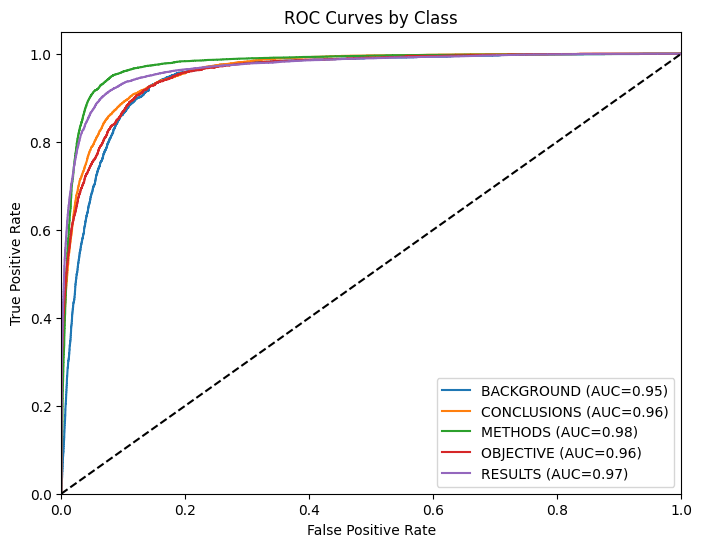

In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import f1_score, roc_auc_score, classification_report, confusion_matrix, roc_curve, auc
import tensorflow as tf
from tensorflow.keras import regularizers

# Check for GPU
gpus = tf.config.list_physical_devices('GPU')
if not gpus:
    print("No GPU detected. Exiting script.")
    sys.exit(1)
else:
    print("GPU detected:", tf.test.gpu_device_name())

# Load and prepare data
def prepare_data(path):
    records = []
    with open(path, 'r', encoding='utf-8') as f:
        current_id = None
        count = 0
        for raw in f:
            line = raw.strip()
            if not line:
                continue
            if line.startswith('###'):
                current_id = line[3:]
                count = 1
            else:
                parts = line.split(None, 1)
                label = parts[0]
                text = parts[1] if len(parts) > 1 else ''
                records.append({'id': current_id, 'order': count, 'label': label, 'text': text})
                count += 1
    return pd.DataFrame(records)

# Load dataset
train_path = '../input/200k-abstract-2/train.txt'
df = prepare_data(train_path)

# Label encoding
label_encoder = LabelEncoder()
df['label_enc'] = label_encoder.fit_transform(df['label'])
num_classes = len(label_encoder.classes_)

# Train-validation split
X_train, X_val, y_train, y_val = train_test_split(
    df['text'], df['label_enc'], test_size=0.2, random_state=42, stratify=df['label_enc']
)

X_train = X_train.astype(str).to_numpy()
X_val = X_val.astype(str).to_numpy()
y_train = y_train.astype(np.int32)
y_val = y_val.astype(np.int32)

# Text vectorization
max_tokens = 50000
seq_len = 128
embedding_dim = 200
text_vectorizer = tf.keras.layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode='int',
    output_sequence_length=seq_len
)
text_vectorizer.adapt(X_train)

# Model definition
inputs = tf.keras.Input(shape=(), dtype=tf.string)
x = text_vectorizer(inputs)
x = tf.keras.layers.Embedding(max_tokens, embedding_dim)(x)

conv_blocks = []
for kernel_size in [3, 4, 5]:
    conv = tf.keras.layers.Conv1D(
        filters=64,
        kernel_size=kernel_size,
        activation='relu',
        padding='same',
        kernel_regularizer=regularizers.l2(0.01)
    )(x)
    conv = tf.keras.layers.MaxPooling1D()(conv)
    conv_blocks.append(conv)

x = tf.keras.layers.Concatenate()(conv_blocks)
x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.GlobalAveragePooling1D()(x)
x = tf.keras.layers.Dense(
    128, activation='relu', kernel_regularizer=regularizers.l2(0.01)
)(x)
x = tf.keras.layers.Dropout(0.5)(x)
outputs = tf.keras.layers.Dense(num_classes, activation='softmax')(x)

model = tf.keras.Model(inputs, outputs)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Prepare datasets
batch_size = 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(batch_size)
val_ds = tf.data.Dataset.from_tensor_slices((X_val, y_val)).batch(batch_size)

# Callbacks
callbacks = [
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2)
]

# Train the model
epochs = 20
history = model.fit(train_ds, validation_data=val_ds, epochs=epochs, callbacks=callbacks)

# Evaluate
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)

# Classification report
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

# F1 score
f1 = f1_score(y_val, y_pred, average='weighted')
print(f"Weighted F1 Score: {f1:.4f}")

# AUC score
y_val_bin = tf.keras.utils.to_categorical(y_val, num_classes=num_classes)
auc_score = roc_auc_score(y_val_bin, y_pred_probs, average='macro', multi_class='ovr')
print(f"AUC Score (macro): {auc_score:.4f}")

# Confusion matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Training history plots
plt.figure(figsize=(14, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Load and prepare test set
test_path = '../input/200k-abstract-2/test.txt'
test_df = prepare_data(test_path)
test_df['label_enc'] = label_encoder.transform(test_df['label'])

X_test = test_df['text'].astype(str).to_numpy()
y_test = test_df['label_enc'].astype(np.int32).to_numpy()

# Predict on test set
y_test_probs = model.predict(X_test)
y_test_pred = np.argmax(y_test_probs, axis=1)

# Evaluate on test
print("\n--- Final Test Set Evaluation ---")
print(classification_report(y_test, y_test_pred, target_names=label_encoder.classes_))

f1_test = f1_score(y_test, y_test_pred, average='weighted')
print(f"Test F1 Score: {f1_test:.4f}")

y_test_bin = tf.keras.utils.to_categorical(y_test, num_classes=num_classes)
auc_test = roc_auc_score(y_test_bin, y_test_probs, average='macro', multi_class='ovr')
print(f"Test AUC Score: {auc_test:.4f}")

# ROC Curves by Class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_test_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))
for i in range(num_classes):
    plt.plot(fpr[i], tpr[i], label=f"{label_encoder.classes_[i]} (AUC={roc_auc[i]:.2f})")

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves by Class')
plt.legend(loc='lower right')
plt.show()
